# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission.*

In this exercise, you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [63]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [64]:
% pwd
% ls
% cd /content/gdrive/'My Drive'/'ComputerVision'/'50.035 Computer Vision'/'Lab1-Week2'
% ls

classifiers/   data_utils.pyc      imgs/        knn.ipynb      vis_utils.py
datasets/      gradient_check.py   __init__.py  __pycache__/
data_utils.py  gradient_check.pyc  knn.html     softmax.ipynb
/content/gdrive/My Drive/ComputerVision/50.035 Computer Vision/Lab1-Week2
classifiers/   data_utils.pyc      imgs/        knn.ipynb      vis_utils.py
datasets/      gradient_check.py   __init__.py  __pycache__/
data_utils.py  gradient_check.pyc  knn.html     softmax.ipynb


**Acknowledgement: This exercise is adapted from [Stanford CS231n](http://cs231n.stanford.edu/).**

In [0]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [0]:
def rel_error(out, correct_out):
    return np.sum(abs(out - correct_out) / (abs(out) + abs(correct_out)))

In [8]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    Softmax, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    # # We will also make a development set, which is a small subset of
    # the training set.
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


In [0]:
# Create one-hot vectors for label
num_class = 10
y_train_oh = np.zeros((y_train.shape[0], 10))
y_train_oh[np.arange(y_train.shape[0]), y_train] = 1
y_val_oh = np.zeros((y_val.shape[0], 10))
y_val_oh[np.arange(y_val.shape[0]), y_val] = 1
y_test_oh = np.zeros((y_test.shape[0], 10))
y_test_oh[np.arange(y_test.shape[0]), y_test] = 1

y_dev_oh = np.zeros((y_dev.shape[0], 10))
y_dev_oh[np.arange(y_dev.shape[0]), y_dev] = 1

In [10]:
print(y_dev_oh[1])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


# Regression as classifier
The most simple and straightforward approach to learn a classifier is to map the input data (raw image values) to class label (one-hot vector). The loss function is defined as following: 
$$\mathcal{L}=\frac{1}{n}\|\mathbf{X}\mathbf{W}-\mathbf{y}\|_F^2\qquad\qquad(1)$$
Where:
* $\mathbf{W}\in \mathbb{R}^{(d+1)\times C}$: Classifier weight
* $\mathbf{X}\in \mathbb{R}^{n\times (d+1)}$: Dataset
* $\mathbf{y}\in \mathbb{R}^{n\times C}$: Class label (one-hot vector)

# Optimization
Given the loss function (1), the next problem is how to solve the weight $\mathbf{W}$. We now discuss 2 approaches: 
 * Random search
 * Closed-form solution

## Random search

In [11]:
bestloss = float('inf')
for num in range(100):
    W = np.random.randn(3073, 10) * 0.0001
    loss = np.linalg.norm(X_dev.dot(W) - y_dev_oh)
    if (loss < bestloss):
        bestloss = loss
        bestW = W
    print('in attempt %d the loss was %f, best %f' % (num, loss, bestloss))

in attempt 0 the loss was 33.220927, best 33.220927
in attempt 1 the loss was 35.336528, best 33.220927
in attempt 2 the loss was 36.349952, best 33.220927
in attempt 3 the loss was 33.264245, best 33.220927
in attempt 4 the loss was 33.722160, best 33.220927
in attempt 5 the loss was 32.766837, best 32.766837
in attempt 6 the loss was 32.862774, best 32.766837
in attempt 7 the loss was 33.026803, best 32.766837
in attempt 8 the loss was 32.304954, best 32.304954
in attempt 9 the loss was 32.759941, best 32.304954
in attempt 10 the loss was 35.154663, best 32.304954
in attempt 11 the loss was 32.786710, best 32.304954
in attempt 12 the loss was 34.045228, best 32.304954
in attempt 13 the loss was 34.422591, best 32.304954
in attempt 14 the loss was 35.023994, best 32.304954
in attempt 15 the loss was 33.858456, best 32.304954
in attempt 16 the loss was 31.395205, best 31.395205
in attempt 17 the loss was 35.994833, best 31.395205
in attempt 18 the loss was 32.942437, best 31.395205
in 

In [12]:
# How bestW perform:
print('Accuracy on train set: ', np.sum(np.argmin(np.abs(1 - X_dev.dot(W)), axis=1) == y_dev).astype(np.float32)/y_dev.shape[0]*100)
print('Accuracy on test set: ', np.sum(np.argmin(np.abs(1 - X_test.dot(W)), axis=1) == y_test).astype(np.float32)/y_test.shape[0]*100)

Accuracy on train set:  11.200000000000001
Accuracy on test set:  10.9


You can clearly see that the performance is very low, almost at the random level.

## Closed-form solution
The closed-form solution is achieved by:
$$\frac{\partial\mathcal{L}}{\partial \mathbf{W}}=\frac{2}{n}\mathbf{X}^T(\mathbf{X}\mathbf{W}-\mathbf{y})=0$$

$$\Leftrightarrow\mathbf{W}^\ast=(\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

In [0]:
################################################################################
# TODO:                                                                        #
# Implement the closed-form solution of the weight W.                          #
################################################################################
W = np.dot(np.linalg.inv(np.dot(np.transpose(X_train),X_train)),np.dot(np.transpose(X_train),y_train_oh))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

In [14]:
# Check accuracy:
print('Train set accuracy: ', np.sum(np.argmin(np.abs(1 - X_train.dot(W)), axis=1) == y_train).astype(np.float32)/y_train.shape[0]*100)
print('Test set accuracy: ', np.sum(np.argmin(np.abs(1 - X_test.dot(W)), axis=1) == y_test).astype(np.float32)/y_test.shape[0]*100)

Train set accuracy:  51.163265306122454
Test set accuracy:  36.199999999999996


Now, you can see that the performance is much better.

## Regularization
A simple way to improve performance is to include the L2-regularization penalty.
$$\mathcal{L}=\frac{1}{n}\|\mathbf{X}\mathbf{W}-\mathbf{y}\|_F^2 +\lambda \|\mathbf{W}\|_F^2 \qquad\qquad(2)$$
The closed-form solution now is: 
$$\Leftrightarrow\mathbf{W}^\ast=(\mathbf{X}^T\mathbf{X}+\lambda n\mathbf{I})^{-1}\mathbf{X}^T\mathbf{y}$$

In [15]:
# try several values of lambda to see how it helps:
lambdas = [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
train_acc = np.zeros((len(lambdas)))
test_acc = np.zeros((len(lambdas)))
for i in range(len(lambdas)):
    l = lambdas[i]
    n,d = X_train.shape[0], X_train.shape[1]
    print(n,d)
    ################################################################################
    # TODO:                                                                        #
    # Implement the closed-form solution of the weight W with regularization.      #
    ################################################################################
    W = np.dot(np.linalg.inv(np.add(np.dot(np.transpose(X_train),X_train),l*n*np.identity(d))),np.dot(np.transpose(X_train),y_train_oh))
    ################################################################################
    #                              END OF YOUR CODE                                #
    ################################################################################
    train_acc[i] = np.sum(np.argmin(np.abs(1 - X_train.dot(W)), axis=1) == y_train).astype(np.float32)/y_train.shape[0]*100
    test_acc[i]  = np.sum(np.argmin(np.abs(1 - X_test.dot(W)), axis=1) == y_test).astype(np.float32)/y_test.shape[0]*100

49000 3073
49000 3073
49000 3073
49000 3073
49000 3073
49000 3073
49000 3073
49000 3073


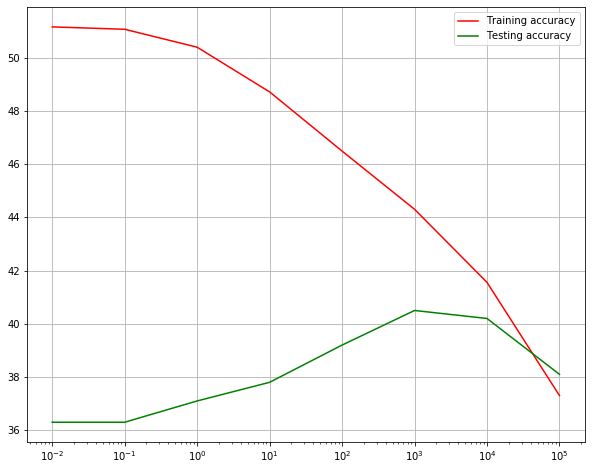

In [16]:
plt.semilogx(lambdas, train_acc, 'r', label="Training accuracy")
plt.semilogx(lambdas, test_acc, 'g', label="Testing accuracy")

plt.legend()
plt.grid(True)
plt.show()

**Question:** Try to explain why the performances on the training and test set have such behaviors as we change the value of $\lambda$.

**Your answer:**  Regularization in machine learning is the process of regularizing the parameters that constrain, regularizes, or shrinks the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, avoiding the risk of Overfitting.

Therefore, as the regularization parameter - 𝜆 increases, the training accuracy falls and training accuracy increases. This is because it dynamically allows the model to not overfit with the test data and be general enough to predict test data. Also, after it reaches a specific large number of the parameter, the test accuracy also starts to fall. This is because  our model tries hard to minimize the weights without accurately minimizing the loss function.



## Softmax Classifier

The predicted probability for the $j$-th class given a sample vector $x$ and a weight $W$ is:

$$\displaystyle{P(y=j\mid x)=\frac{e^{-xw_j}}{\sum\limits_{c=1}^{C}e^{-xw_c}}}$$ 

![softmax](imgs/softmax.png "Example of Softmax")

Your code for this section will all be written inside **classifiers/softmax.py**. 


In [17]:
# First implement the naive softmax loss function with nested loops.
# Open the file classifiers/softmax.py and implement the
# softmax_loss_naive function.

from classifiers.softmax import softmax_loss_naive
import time
import math

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1.5)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.327537
sanity check: 2.302585


**Question:** Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** We want the probability of the correct class to be maximised. This in turn aims to minimize Loss - -log(.) . Hence, our loss is close to -log(0.1) as it is minimized. 

# Optimization


## Random search

In [18]:
bestloss = float('inf')
for num in range(100):
    W = np.random.randn(3073, 10) * 0.0001
    loss, _ = softmax_loss_naive(W, X_dev, y_dev, 0.0)
    if (loss < bestloss):
        bestloss = loss
        bestW = W
    print('in attempt %d the loss was %f, best %f' % (num, loss, bestloss))

in attempt 0 the loss was 2.438061, best 2.438061
in attempt 1 the loss was 2.353914, best 2.353914
in attempt 2 the loss was 2.349891, best 2.349891
in attempt 3 the loss was 2.325859, best 2.325859
in attempt 4 the loss was 2.386877, best 2.325859
in attempt 5 the loss was 2.376974, best 2.325859
in attempt 6 the loss was 2.338215, best 2.325859
in attempt 7 the loss was 2.367791, best 2.325859
in attempt 8 the loss was 2.387139, best 2.325859
in attempt 9 the loss was 2.366352, best 2.325859
in attempt 10 the loss was 2.333570, best 2.325859
in attempt 11 the loss was 2.328531, best 2.325859
in attempt 12 the loss was 2.354842, best 2.325859
in attempt 13 the loss was 2.401608, best 2.325859
in attempt 14 the loss was 2.388703, best 2.325859
in attempt 15 the loss was 2.379910, best 2.325859
in attempt 16 the loss was 2.383777, best 2.325859
in attempt 17 the loss was 2.368721, best 2.325859
in attempt 18 the loss was 2.304804, best 2.304804
in attempt 19 the loss was 2.338666, best

In [19]:
# How bestW perform on trainset
scores = X_train.dot(bestW)
y_pred = np.argmax(scores, axis=1)
print('Accuracy on train set %f' % np.mean(y_pred == y_train))

# evaluate performance of test set
scores = X_test.dot(bestW)
y_pred = np.argmax(scores, axis=1)
print('Accuracy on test set %f' % np.mean(y_pred == y_test))

Accuracy on train set 0.133020
Accuracy on test set 0.141000


Compare the performance when using random search with *regression classifier* and *softmax classifier*. You can see how much useful the softmax classifier is.

## Stochastic Gradient descent
Even though it is possible to achieve closed-form solution with softmax classifier, it would be more complicated. In fact, we could achieve very good results with gradient descent approach. Additionally, in case of very large dataset, it is impossible to load the whole dataset into the memory. Gradient descent can help to optimize the loss function in batch. 

$$\mathbf{W}^{t+1}=\mathbf{W}^{t}−\alpha \frac{\partial\mathcal{L(\mathbf{x};\mathbf{W}^{t})}}{\partial\mathbf{W}^{t}}$$

Where $\alpha$ is the learning rate, $\mathcal{L}$ is a loss function, and $\mathbf{x}$ is a batch of training dataset.

In [20]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.724706 analytic: -1.724706, relative error: 1.707114e-08
numerical: -5.605044 analytic: -5.605044, relative error: 8.938882e-09
numerical: -7.730315 analytic: -7.730315, relative error: 5.351505e-09
numerical: 2.331733 analytic: 2.331733, relative error: 5.132660e-09
numerical: 2.285163 analytic: 2.285163, relative error: 3.218937e-09
numerical: -0.569149 analytic: -0.569149, relative error: 8.960560e-08
numerical: 2.520460 analytic: 2.520460, relative error: 1.706582e-08
numerical: -3.041227 analytic: -3.041227, relative error: 1.644397e-08
numerical: 3.822709 analytic: 3.822709, relative error: 2.953980e-09
numerical: -1.500822 analytic: -1.500822, relative error: 7.328889e-09
numerical: -1.435693 analytic: -1.435693, relative error: 5.877750e-10
numerical: 0.266809 analytic: 0.266809, relative error: 1.057714e-07
numerical: -3.395643 analytic: -3.395643, relative error: 8.792157e-09
numerical: -0.935705 analytic: -0.935705, relative error: 1.446306e-08
numerical: -2.90

In [21]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.347862e+00 computed in 0.161884s
vectorized loss: 2.347862e+00 computed in 0.011277s
Loss difference: 0.000000
Gradient difference: 0.000000


In [68]:
from classifiers.linear_classifier import *

classifier = Softmax()
tic = time.time()
loss_hist = classifier.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                                  num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

(49000, 3073)
iteration 0 / 1500: loss 769.261805
iteration 100 / 1500: loss 282.137547
iteration 200 / 1500: loss 104.520471
iteration 300 / 1500: loss 39.616826
iteration 400 / 1500: loss 15.743353
iteration 500 / 1500: loss 7.133816
iteration 600 / 1500: loss 3.852601
iteration 700 / 1500: loss 2.784871
iteration 800 / 1500: loss 2.350191
iteration 900 / 1500: loss 2.169335
iteration 1000 / 1500: loss 2.110525
iteration 1100 / 1500: loss 2.077467
iteration 1200 / 1500: loss 2.075770
iteration 1300 / 1500: loss 2.060840
iteration 1400 / 1500: loss 2.068111
That took 6.992247s


In [71]:
# Write the Softmax.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = classifier.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

(49000,)
(49000,)
training accuracy: 0.326429
(1000,)
(1000,)
validation accuracy: 0.338000


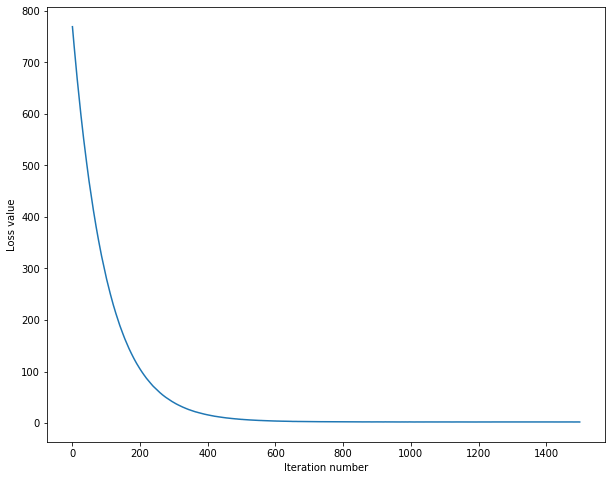

In [72]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [73]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = classifier.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %.2f' % (100*test_accuracy, ))

(1000,)
(1000,)
softmax on raw pixels final test set accuracy: 34.20
